# 1. 介绍
针对低纬度的有约束的优化问题，在这一节，我们将介绍Seidels 线形规划算法，并且提供三个例子。

# 1.1 洗牌算法
用于得到一个等概率的抽象，来保证算法的稳定性。

## 1.2 Seidels LP 算法

Seidel's LP 算法是一个用于解决低维线性规划问题的随机化算法。该算法通过递归的方式逐步降低问题的维度，直到问题简化为一维情况。

### 算法特点：
- **时间复杂度**：O(d!n) 一般情况，但当维度d固定在{1,...,9}范围内时，复杂度为O(n)，即关于约束数量n线性
- **随机化策略**：通过随机选择约束的顺序来保证算法的期望性能
- **递归结构**：每次递归都会使用高斯消元法降低一个维度

### 算法流程：
1. 如果问题是一维的，直接调用一维LP求解器
2. 随机排列所有约束
3. 对每个约束h，检查当前解x是否满足约束
4. 如果不满足，使用高斯消元法将问题降维，递归求解
5. 将处理过的约束加入集合I中

### 伪代码表示
Algorithm SeidelsLP(c, A, b, d)
Input: 
    - c: 目标函数系数向量 (d维)
    - A: 约束矩阵 (n×d)
    - b: 约束右端向量 (n维)
    - d: 问题维度

Output: 最优解 x* 或 "unbounded"/"infeasible"

Begin:
1. If d = 1 Then
         Return SolveLP1D(c, A, b)  // 调用一维LP求解器
     
2. 随机排列约束 {1, 2, ..., n}，得到排列 π
     
3. I ← ∅  // 已处理的约束集合
     
4. x ← 解决LP(c, A_I, b_I, d)  // 求解无约束问题或当前约束集合的问题
     
5. For h = π(1), π(2), ..., π(n) Do:
         If A_h · x > b_h Then  // 当前解违反约束h
             // 使用高斯消元降维
             选择 |A_h[j]| 最大的 j 作为主元
             构造降维后的问题：
                 c' ← Gaussian_Eliminate(c, A_h, j)
                 A' ← Gaussian_Eliminate(A_I ∪ {h}, A_h, j)  
                 b' ← Gaussian_Eliminate(b_I ∪ {h}, A_h, j)
             
             x' ← SeidelsLP(c', A', b', d-1)  // 递归求解d-1维问题
             
             If x' = "unbounded" or x' = "infeasible" Then
                 Return x'
             
             // 恢复到d维空间
             x ← Recover_Solution(x', A_h, b_h, j)
         
         I ← I ∪ {h}  // 将约束h加入已处理集合
     
6. Return x
End


### 关键技术：
- **高斯消元**：用于在递归前降低问题维度，选择绝对值最大的系数作为主元确保数值稳定性
- **随机化**：通过随机处理约束顺序来避免最坏情况的发生


=== 示例1: 2D线性规划问题 ===
问题1解: [0.0, 0.0]
目标函数值: 0.0


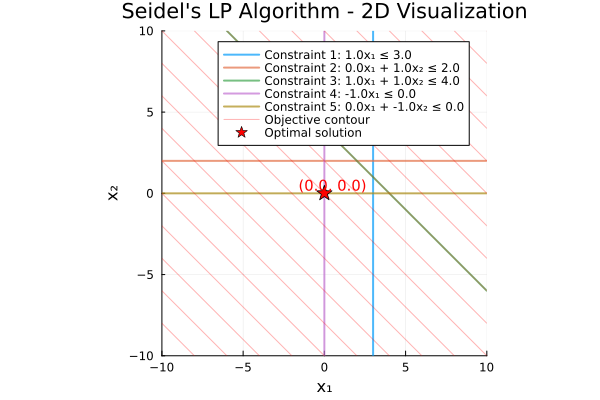

In [1]:
using LinearAlgebra, Plots, Random

# Fisher-Yates 洗牌算法
function shuffle_constraints(n)
    perm = collect(1:n)
    for i in n:-1:2
        j = rand(1:i)
        perm[i], perm[j] = perm[j], perm[i]
    end
    return perm
end

# 一维线性规划求解器
function solve_lp_1d(c, A, b)
    if abs(c[1]) < 1e-10
        # 目标函数系数为0，检查可行性
        if all(b .>= -1e-10)
            return [0.0]  # 任意可行解
        else
            return "infeasible"
        end
    end
    
    # 找到最优解
    if c[1] > 0
        # 最大化情况，找上界
        upper_bounds = []
        for i in 1:length(b)
            if A[i, 1] > 1e-10
                push!(upper_bounds, b[i] / A[i, 1])
            end
        end
        if isempty(upper_bounds)
            return "unbounded"
        else
            return [minimum(upper_bounds)]
        end
    else
        # 最小化情况，找下界
        lower_bounds = []
        for i in 1:length(b)
            if A[i, 1] < -1e-10
                push!(lower_bounds, b[i] / A[i, 1])
            end
        end
        if isempty(lower_bounds)
            return "unbounded"
        else
            return [maximum(lower_bounds)]
        end
    end
end

# 高斯消元法
function gaussian_eliminate(c, A, b, constraint_row, pivot_col)
    n, d = size(A)
    
    # 新的维度
    new_d = d - 1
    new_c = zeros(new_d)
    new_A = zeros(n-1, new_d)
    new_b = zeros(n-1)
    
    # 主元
    pivot = A[constraint_row, pivot_col]
    
    # 构造新的目标函数
    col_idx = 1
    for j in 1:d
        if j != pivot_col
            new_c[col_idx] = c[j] - c[pivot_col] * A[constraint_row, j] / pivot
            col_idx += 1
        end
    end
    
    # 构造新的约束矩阵和右端向量
    row_idx = 1
    for i in 1:n
        if i != constraint_row
            col_idx = 1
            for j in 1:d
                if j != pivot_col
                    new_A[row_idx, col_idx] = A[i, j] - A[i, pivot_col] * A[constraint_row, j] / pivot
                    col_idx += 1
                end
            end
            new_b[row_idx] = b[i] - A[i, pivot_col] * b[constraint_row] / pivot
            row_idx += 1
        end
    end
    
    return new_c, new_A, new_b
end

# 恢复解到原维度
function recover_solution(x_reduced, constraint_row, A, b, pivot_col)
    d = size(A, 2)
    x_full = zeros(d)
    
    # 计算主元变量的值
    pivot_val = b[constraint_row]
    col_idx = 1
    for j in 1:d
        if j != pivot_col
            pivot_val -= A[constraint_row, j] * x_reduced[col_idx]
            col_idx += 1
        end
    end
    pivot_val /= A[constraint_row, pivot_col]
    
    # 构造完整解
    col_idx = 1
    for j in 1:d
        if j == pivot_col
            x_full[j] = pivot_val
        else
            x_full[j] = x_reduced[col_idx]
            col_idx += 1
        end
    end
    
    return x_full
end

# Seidel's LP 算法主函数
function seidels_lp(c, A, b, d=nothing)
    if d === nothing
        d = length(c)
    end
    
    n = size(A, 1)
    
    # 基本情况：一维问题
    if d == 1
        return solve_lp_1d(c, A, b)
    end
    
    # 随机排列约束
    perm = shuffle_constraints(n)
    
    # 初始化
    I = Int[]  # 已处理的约束集合
    
    # 初始解（无约束最优解）
    if norm(c) < 1e-10
        x = zeros(d)
    else
        # 对于线性规划，无约束问题通常是无界的
        x = zeros(d)  # 从原点开始
    end
    
    # 逐个处理约束
    for h in perm
        # 检查当前解是否满足约束h
        if dot(A[h, :], x) > b[h] + 1e-10
            # 违反约束，需要降维求解
            
            # 选择主元（绝对值最大的系数）
            pivot_col = argmax(abs.(A[h, :]))
            
            if abs(A[h, pivot_col]) < 1e-10
                # 所有系数都接近0，检查可行性
                if b[h] < -1e-10
                    return "infeasible"
                else
                    continue
                end
            end
            
            # 构造当前约束集合
            current_constraints = [I; h]
            A_current = A[current_constraints, :]
            b_current = b[current_constraints]
            
            # 高斯消元降维
            c_reduced, A_reduced, b_reduced = gaussian_eliminate(c, A_current, b_current, 
                                                               length(current_constraints), pivot_col)
            
            # 递归求解降维问题
            x_reduced = seidels_lp(c_reduced, A_reduced, b_reduced, d-1)
            
            if x_reduced == "unbounded" || x_reduced == "infeasible"
                return x_reduced
            end
            
            # 恢复到原维度
            x = recover_solution(x_reduced, length(current_constraints), A_current, b_current, pivot_col)
        end
        
        # 将约束h加入已处理集合
        push!(I, h)
    end
    
    return x
end

# 可视化函数（2D情况）
function visualize_lp_2d(c, A, b, solution=nothing)
    if length(c) != 2
        println("可视化仅支持2D问题")
        return
    end
    
    # 创建网格
    x_range = -10:0.1:10
    y_range = -10:0.1:10
    
    plt = plot(xlims=(-10, 10), ylims=(-10, 10), aspect_ratio=:equal, 
               title="Seidel's LP Algorithm - 2D Visualization",
               xlabel="x₁", ylabel="x₂")
    
    # 绘制约束线
    for i in 1:size(A, 1)
        if abs(A[i, 2]) > 1e-10
            # y = (b[i] - A[i,1]*x) / A[i,2]
            x_vals = collect(x_range)
            y_vals = [(b[i] - A[i, 1] * x) / A[i, 2] for x in x_vals]
            plot!(plt, x_vals, y_vals, label="Constraint $i: $(A[i,1])x₁ + $(A[i,2])x₂ ≤ $(b[i])", 
                  linewidth=2, alpha=0.7)
        elseif abs(A[i, 1]) > 1e-10
            # 垂直线 x = b[i]/A[i,1]
            x_val = b[i] / A[i, 1]
            plot!(plt, [x_val, x_val], [minimum(y_range), maximum(y_range)], 
                  label="Constraint $i: $(A[i,1])x₁ ≤ $(b[i])", linewidth=2, alpha=0.7)
        end
    end
    
    # 绘制目标函数等高线
    if norm(c) > 1e-10
        obj_levels = -20:2:20
        for level in obj_levels
            if abs(c[2]) > 1e-10
                x_vals = collect(x_range)
                y_vals = [(level - c[1] * x) / c[2] for x in x_vals]
                plot!(plt, x_vals, y_vals, color=:red, alpha=0.3, linewidth=1, 
                      label=level == obj_levels[1] ? "Objective contour" : "")
            end
        end
    end
    
    # 绘制解
    if solution !== nothing && solution != "unbounded" && solution != "infeasible"
        scatter!(plt, [solution[1]], [solution[2]], color=:red, markersize=8, 
                label="Optimal solution", markershape=:star)
        annotate!(plt, solution[1]+0.5, solution[2]+0.5, 
                 text("($(round(solution[1], digits=2)), $(round(solution[2], digits=2)))", 
                      :red, 10))
    end
    
    return plt
end


# 示例1：简单的2D线性规划问题
println("=== 示例1: 2D线性规划问题 ===")
c1 = [1.0, 1.0]  # 目标函数: max x₁ + x₂
A1 = [1.0 0.0;    # x₁ ≤ 3
      0.0 1.0;    # x₂ ≤ 2  
      1.0 1.0;    # x₁ + x₂ ≤ 4
      -1.0 0.0;   # x₁ ≥ 0
      0.0 -1.0]   # x₂ ≥ 0
b1 = [3.0, 2.0, 4.0, 0.0, 0.0]

sol1 = seidels_lp(c1, A1, b1)
println("问题1解: ", sol1)
println("目标函数值: ", dot(c1, sol1))

# 可视化示例1
plot1 = visualize_lp_2d(c1, A1, b1, sol1)
display(plot1)

# 2.1 Linear Separability问题
线形可分问题，用来判断两个pologon是否相撞，更一般的是，判断3D物体是否碰撞，不使用AABB碰撞包围盒时的算法。

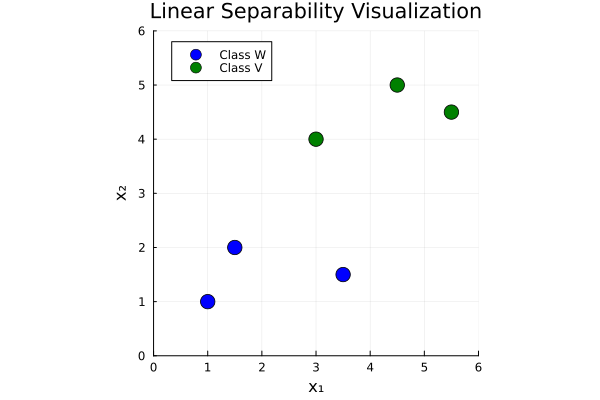

Linear Separability 问题解: infeasible


In [2]:
# 示例2：Linear Separability 问题的可视化与求解

# 假设有两组点 w 和 v，判断是否线性可分
w = [ [1.5, 2.0], [1.0, 1.0], [3.5, 1.5] ]  # 第一组点
v = [ [4.5, 5.0], [3.0, 4.0], [5.5, 4.5] ]  # 第二组点

# 构造线性可分的LP约束
# 寻找 a, b 使得 a'w_i ≤ b - 1, a'v_j ≥ b + 1
# 即 a'w_i - b ≤ -1, a'v_j - b ≥ 1  <=> -a'v_j + b ≤ -1
# 变量为 [a1, a2, b]

n_w = length(w)
n_v = length(v)
# ...existing code...
# 变量为 [a1, a2, b, γ]
d = 2
n_var = d + 2  # [a1, a2, b, γ]

A_sep = zeros(n_w + n_v + 2, n_var)
b_sep = zeros(n_w + n_v + 2)

# w组约束: a'w_i - b ≤ -γ
for i in 1:n_w
    A_sep[i, 1:d] .= w[i]
    A_sep[i, d+1] = -1.0
    A_sep[i, d+2] = 1.0   # γ
    b_sep[i] = 0.0
end

# v组约束: a'v_j - b ≥ γ  <=> -a'v_j + b + γ ≤ 0
for j in 1:n_v
    A_sep[n_w + j, 1:d] .= -v[j]
    A_sep[n_w + j, d+1] = 1.0
    A_sep[n_w + j, d+2] = 1.0   # γ
    b_sep[n_w + j] = 0.0
end

# 归一化约束 a1 = 1
A_sep[n_w + n_v + 1, :] .= 0.0
A_sep[n_w + n_v + 1, 1] = 1.0
b_sep[n_w + n_v + 1] = 1.0

epsilon = 1e-3

# γ ≥ ε
A_sep[n_w + n_v + 2, :] .= 0.0
A_sep[n_w + n_v + 2, d+2] = -1.0
b_sep[n_w + n_v + 2] = -epsilon

# 目标函数：最大化 γ
c_sep = zeros(n_var)
c_sep[end] = -1.0  # maximize γ

sol_sep = seidels_lp(c_sep, A_sep, b_sep)
println("Linear Separability 问题解: ", sol_sep)

# 可视化
plt_sep = plot(xlims=(0, 6), ylims=(0, 6), aspect_ratio=:equal, 
               title="Linear Separability Visualization",
               xlabel="x₁", ylabel="x₂")

scatter!(plt_sep, [p[1] for p in w], [p[2] for p in w], color=:blue, label="Class W", markersize=8)
scatter!(plt_sep, [p[1] for p in v], [p[2] for p in v], color=:green, label="Class V", markersize=8)

if sol_sep != "infeasible" && sol_sep != "unbounded"
    a = sol_sep[1:2]
    b_val = sol_sep[3]
    # 超平面: a₁x₁ + a₂x₂ = b
    if abs(a[2]) > 1e-10
        x_vals = 0:0.1:6
        y_vals = [(b_val - a[1]*x)/a[2] for x in x_vals]
        plot!(plt_sep, x_vals, y_vals, color=:red, linewidth=2, label="Separating Hyperplane")
    elseif abs(a[1]) > 1e-10
        x_val = b_val / a[1]
        plot!(plt_sep, [x_val, x_val], [0, 6], color=:red, linewidth=2, label="Separating Hyperplane")
    end
end

display(plt_sep)

In [3]:
# 定义AABB结构体
struct AABB
    xmin::Float64
    xmax::Float64
    ymin::Float64
    ymax::Float64
end

# 判断两个AABB是否碰撞
function is_aabb_collide(a::AABB, b::AABB)
    # 只要有一个轴不重叠就不碰撞
    if a.xmax < b.xmin || a.xmin > b.xmax
        return false
    end
    if a.ymax < b.ymin || a.ymin > b.ymax
        return false
    end
    return true
end

# 示例
a = AABB(1.0, 3.0, 2.0, 4.0)
b = AABB(2.5, 4.0, 3.5, 5.0)
println(is_aabb_collide(a, b))  # 输出 true

# 计算一组点的AABB
function points_to_aabb(points)
    xs = [p[1] for p in points]
    ys = [p[2] for p in points]
    return AABB(minimum(xs), maximum(xs), minimum(ys), maximum(ys))
end

# 用w和v生成AABB
a = points_to_aabb(w)
b = points_to_aabb(v)

println("AABB a: ", a)
println("AABB b: ", b)
println("是否碰撞: ", is_aabb_collide(a, b))

true
AABB a: AABB(1.0, 3.5, 1.0, 2.0)
AABB b: AABB(3.0, 5.5, 4.0, 5.0)
是否碰撞: false


# 2.2 cicular separability 圆心可分
这里类似于机器学习中在学习回归算法中的升纬方法，现将变量映射到高阶圆上，再对升上去的阶的结果做 linear separability。

## 2.3 Chebyshev Center 切比雪夫中心
用于确定，机器人在环境中，最安全在哪，这个点距离所有obstacle是最远的！
记e4=(0 1)', x_bar =(x y)', x 属于 R^3, y属于r, 

这个问题描述为
max y<
s.t. for all ai'x+y <= b
-> max e4'(A,1)x_bar<=b



=== 示例3: Chebyshev Center 问题 ===
Chebyshev Center 解: [2.0, 1.0, -0.0]
最优中心点: (2.0, 1.0)
最大内切圆半径: -0.0

=== 验证Chebyshev中心解 ===
约束 1: 点到边界距离 = 6.0, 半径 = -0.0
约束 2: 点到边界距离 = 0.0, 半径 = -0.0
约束 3: 点到边界距离 = 5.0, 半径 = -0.0
约束 4: 点到边界距离 = 0.0, 半径 = -0.0
约束 5: 点到边界距离 = 3.5355, 半径 = -0.0
约束 6: 点到边界距离 = 2.1213, 半径 = -0.0


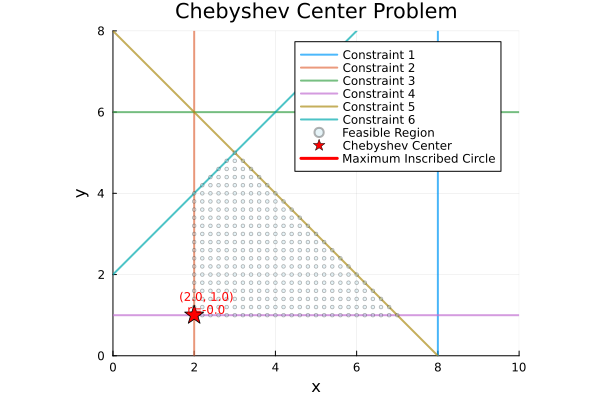

In [4]:
# 示例3：Chebyshev Center 问题
println("=== 示例3: Chebyshev Center 问题 ===")

# 定义多边形约束 Ax ≤ b (表示障碍物边界)
# 这里我们定义一个简单的多边形区域，求其Chebyshev中心
A_cheby = [1.0 0.0;      # x ≤ 8
          -1.0 0.0;      # -x ≤ -2, 即 x ≥ 2  
          0.0 1.0;       # y ≤ 6
          0.0 -1.0;      # -y ≤ -1, 即 y ≥ 1
          1.0 1.0;       # x + y ≤ 8
          -1.0 1.0]      # -x + y ≤ 2, 即 y - x ≤ 2

b_cheby = [8.0, -2.0, 6.0, -1.0, 8.0, 2.0]

# 构造Chebyshev中心问题
# 变量: [x, y, r] 其中r是内切圆半径
# 约束: 对每个原约束 ai'x ≤ bi，转换为 ai'x + ||ai||*r ≤ bi
# 目标: 最大化 r

n_constraints = size(A_cheby, 1)
A_cheby_lp = zeros(n_constraints + 1, 3)  # [x, y, r] + 一个约束r >= 0
b_cheby_lp = zeros(n_constraints + 1)

for i in 1:n_constraints
    A_cheby_lp[i, 1:2] .= A_cheby[i, :]  # 原约束系数
    A_cheby_lp[i, 3] = norm(A_cheby[i, :])  # ||ai|| 作为r的系数
    b_cheby_lp[i] = b_cheby[i]
end

# 添加约束 r ≥ 0，即 -r ≤ 0
A_cheby_lp[n_constraints + 1, :] = [0.0, 0.0, -1.0]
b_cheby_lp[n_constraints + 1] = 0.0

# 目标函数: 最大化 r，即最小化 -r
c_cheby = [0.0, 0.0, -1.0]

sol_cheby = seidels_lp(c_cheby, A_cheby_lp, b_cheby_lp)
println("Chebyshev Center 解: ", sol_cheby)

if sol_cheby != "infeasible" && sol_cheby != "unbounded"
    center = sol_cheby[1:2]
    radius = sol_cheby[3]
    println("最优中心点: ($(round(center[1], digits=2)), $(round(center[2], digits=2)))")
    println("最大内切圆半径: $(round(radius, digits=2))")
end

# 可视化Chebyshev Center
function visualize_chebyshev(A, b, solution=nothing)
    plt = plot(xlims=(0, 10), ylims=(0, 8), aspect_ratio=:equal,
               title="Chebyshev Center Problem",
               xlabel="x", ylabel="y")
    
    # 绘制可行域边界
    x_range = 0:0.1:10
    y_range = 0:0.1:8
    
    for i in 1:size(A, 1)
        if abs(A[i, 2]) > 1e-10
            x_vals = collect(x_range)
            y_vals = [(b[i] - A[i, 1] * x) / A[i, 2] for x in x_vals]
            plot!(plt, x_vals, y_vals, 
                  label="Constraint $i", linewidth=2, alpha=0.7)
        elseif abs(A[i, 1]) > 1e-10
            x_val = b[i] / A[i, 1]
            plot!(plt, [x_val, x_val], [minimum(y_range), maximum(y_range)], 
                  label="Constraint $i", linewidth=2, alpha=0.7)
        end
    end
    
    # 填充可行域
    # 创建网格点来可视化可行域
    x_grid = 0:0.2:10
    y_grid = 0:0.2:8
    feasible_x = Float64[]
    feasible_y = Float64[]
    
    for x in x_grid, y in y_grid
        if all(A * [x, y] .<= b .+ 1e-10)
            push!(feasible_x, x)
            push!(feasible_y, y)
        end
    end
    
    scatter!(plt, feasible_x, feasible_y, color=:lightblue, alpha=0.3, 
             markersize=2, label="Feasible Region")
    
    # 绘制Chebyshev中心和内切圆
    if solution !== nothing && solution != "unbounded" && solution != "infeasible"
        center = solution[1:2]
        radius = solution[3]
        
        # 绘制中心点
        scatter!(plt, [center[1]], [center[2]], color=:red, markersize=10,
                label="Chebyshev Center", markershape=:star)
        
        # 绘制内切圆
        θ = 0:0.1:2π
        circle_x = center[1] .+ radius * cos.(θ)
        circle_y = center[2] .+ radius * sin.(θ)
        plot!(plt, circle_x, circle_y, color=:red, linewidth=3,
              label="Maximum Inscribed Circle")
        
        # 标注
        annotate!(plt, center[1]+0.3, center[2]+0.3,
                 text("($(round(center[1], digits=2)), $(round(center[2], digits=2)))\nr=$(round(radius, digits=2))",
                      :red, 8))
    end
    
    return plt
end

plot_cheby = visualize_chebyshev(A_cheby, b_cheby, sol_cheby)
display(plot_cheby)

# 验证解的正确性
if sol_cheby != "infeasible" && sol_cheby != "unbounded"
    center = sol_cheby[1:2]
    radius = sol_cheby[3]
    
    println("\n=== 验证Chebyshev中心解 ===")
    for i in 1:size(A_cheby, 1)
        constraint_val = dot(A_cheby[i, :], center)
        distance_to_boundary = (b_cheby[i] - constraint_val) / norm(A_cheby[i, :])
        println("约束 $i: 点到边界距离 = $(round(distance_to_boundary, digits=4)), 半径 = $(round(radius, digits=4))")
    end
else
    println("\n问题无解或无界，检查约束定义...")
    println("原约束系统:")
    for i in 1:size(A_cheby, 1)
        println("约束 $i: $(A_cheby[i, 1])x + $(A_cheby[i, 2])y ≤ $(b_cheby[i])")
    end
end

# 3. low-dimentional QP
低纬度的QP问题求解

对于严格凸的低维二次规划问题：
$
\min_{x \in \mathbb{R}^n} \frac{1}{2} x^\top M x + C^\top x, \quad \text{s.t.} \; A x \leq b
$


由于 $M \succ 0$，存在 Cholesky 分解 $M = L L^\top$。该 QP 可等价转化为最小范数问题：


$
y = L^\top x + L^{-1} C \quad \Longleftrightarrow \quad x = L^{-\top} y - (L L^\top)^{-1} C
$
原始 QP 等价于如下更简单的形式：


$
\min_{y \in \mathbb{R}^n} \frac{1}{2} y^\top y, \quad \text{s.t.} \; E y \leq f
$


其中 $E = A L^{-\top}$，$f = A (L L^\top)^{-1} C + b$。

即：**在多面体内找到距离原点最近的点。**

## 对于一阶情况
我们需要判断L和R和origin的关系，如果origin的投影落在L和R的中间，则$y^*=Proj_{h}(origin)$，否则取L、R中离origin近的那个。

## 对于二阶情况
我们需要依次将constraint $h_i$加入进来，并且判断原有的最优点是否满足，如果不满足则投影后再按一阶情况求。

### 对于投影和恢复部分：
我们使用Householder反射矩阵来构造约束超平面的正交基。

**Householder反射矩阵的构造：**

对于约束 $h: g^T y = f$，我们需要找到与向量 $g$ 垂直的正交基。

- 选择合适的标准基向量：选择 $i = \arg\max_k |g_k|$ 来保证数值稳定性
- 计算单位向量 $u = g - ||g||e_i$，其中 $e_i$ 是第 $i$ 个标准基向量
- 构造Householder矩阵： 
    $$
    H = I_d - \frac{2uu^T}{u^T u}
    $$

这个矩阵 $H$ 具有以下性质：

- $H$ 是正交矩阵：$H^T H = I$
- $H$ 有 $(d-1)$ 个与 $g$ 垂直的行向量
- $Hg = ||g||e_i$

**投影到约束超平面：**

- 设新的原点为 $v = \frac{f}{g^T g}g$（约束超平面上距离原点最近的点）
- 在约束超平面 $\mathcal{H}'$ 上的点可以表示为：$y = v + M y'$
- 其中 $M$ 是由 $H$ 的前 $(d-1)$ 行构成的 $(d-1) \times d$ 矩阵，$y'$ 是 $(d-1)$ 维的新变量

**问题降维：**  
原问题 $\min_{y} \frac{1}{2}||y||^2$ 在约束 $g^T y = f$ 下等价于：
$$
\min_{y'} \frac{1}{2}||v + M y'||^2 = \frac{1}{2}||v||^2 + v^T M y' + \frac{1}{2}||M y'||^2
$$

由于 $M$ 的行向量与 $g$ 垂直，且 $v$ 与 $g$ 平行，所以 $v^T M = 0$。

因此问题简化为：$\min_{y'} \frac{1}{2}||y'||^2$

**解的恢复：**

- 在降维空间求得最优解 $y'^*$ 后
- 原空间的解为：$y^* = v + M y'^*$
- 最终通过 $x = L^{-T} y^* - (LL^T)^{-1} C$ 恢复到原始QP问题的解

这种方法的优势在于：

- 保持了问题的凸性
- 数值稳定（通过选择最大分量作为主元）
- 递归结构清晰，适合低维问题



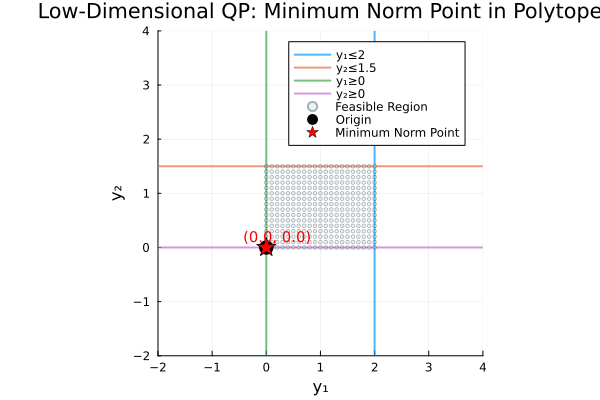

┌ Warning: The keyword argument `silent_solver` in `Convex.solve!` has been deprecated in favor of `silent`.
└ @ Convex /Users/lyu/.julia/packages/Convex/IPPoR/src/solution.jl:93


In [8]:
using Convex, SCS

# 可视化低维最小范数问题（Low-Dimensional QP）算法流程（2D例子）
function visualize_lowdim_qp(E, f; constraints_labels=nothing)
    # 只支持2D
    if size(E, 2) != 2
        println("只支持二维可视化")
        return
    end

    x_range = -5:0.05:5
    y_range = -5:0.05:5

    plt = plot(xlims=(-2, 4), ylims=(-2, 4), aspect_ratio=:equal,
               title="Low-Dimensional QP: Minimum Norm Point in Polytope",
               xlabel="y₁", ylabel="y₂")

    # 绘制约束
    for i in 1:size(E, 1)
        if abs(E[i, 2]) > 1e-10
            x_vals = collect(x_range)
            y_vals = [(f[i] - E[i, 1]*x)/E[i, 2] for x in x_vals]
            plot!(plt, x_vals, y_vals, label=constraints_labels===nothing ? "" : constraints_labels[i], linewidth=2, alpha=0.7)
        elseif abs(E[i, 1]) > 1e-10
            x_val = f[i]/E[i, 1]
            plot!(plt, [x_val, x_val], [minimum(y_range), maximum(y_range)],
                  label=constraints_labels===nothing ? "" : constraints_labels[i], linewidth=2, alpha=0.7)
        end
    end

    # 填充可行域
    x_grid = -2:0.1:4
    y_grid = -2:0.1:4
    feasible_x = Float64[]
    feasible_y = Float64[]
    for x in x_grid, y in y_grid
        if all(E * [x, y] .<= f .+ 1e-8)
            push!(feasible_x, x)
            push!(feasible_y, y)
        end
    end
    scatter!(plt, feasible_x, feasible_y, color=:lightblue, alpha=0.3, markersize=2, label="Feasible Region")

    # 原点
    scatter!(plt, [0.0], [0.0], color=:black, markersize=8, label="Origin", markershape=:circle)

    # 求最小范数点 - 修复版本
    function min_norm_point(E, f)
        n = size(E, 1)
        if n == 0
            return [0.0, 0.0]
        elseif n == 1
            # 投影到直线
            g = E[1, :]
            if dot(g, g) > 1e-10
                α = f[1] / dot(g, g)
                return α * g
            else
                return [0.0, 0.0]
            end
        elseif n == 2
            # 两条直线交点
            try
                A = E
                b = f
                # 检查矩阵是否可逆
                if abs(det(A)) > 1e-10
                    y = A \ b
                    return y
                else
                    # 矩阵奇异，使用投影到第一个约束
                    g = E[1, :]
                    if dot(g, g) > 1e-10
                        α = f[1] / dot(g, g)
                        return α * g
                    else
                        return [0.0, 0.0]
                    end
                end
            catch
                return [0.0, 0.0]
            end
        else
            # 使用Convex.jl求解
            try
                y = Variable(2)
                problem = minimize(sumsquares(y), E * y <= f)
                solve!(problem, SCS.Optimizer; silent_solver=true)
                
                # 检查求解状态
                if problem.status == Convex.MOI.OPTIMAL
                    result = evaluate(y)
                    if result !== nothing
                        return result
                    end
                end
                
                # 如果Convex求解失败，使用简单的投影方法
                println("Convex求解失败，使用备用方法")
                g = E[1, :]
                if dot(g, g) > 1e-10
                    α = f[1] / dot(g, g)
                    return α * g
                else
                    return [0.0, 0.0]
                end
            catch e
                println("优化求解出错: ", e)
                return [0.0, 0.0]
            end
        end
    end

    y_star = min_norm_point(E, f)
    if y_star !== nothing && length(y_star) == 2
        scatter!(plt, [y_star[1]], [y_star[2]], color=:red, markersize=10, label="Minimum Norm Point", markershape=:star)
        annotate!(plt, y_star[1]+0.2, y_star[2]+0.2, text("($(round(y_star[1], digits=2)), $(round(y_star[2], digits=2)))", :red, 10))
    else
        println("无法找到最小范数点")
    end

    return plt
end

# 示例：2D约束
E = [1.0 0.0; 0.0 1.0; -1.0 0.0; 0.0 -1.0]
f = [2.0, 1.5, 0.0, 0.0]
plot_qp = visualize_lowdim_qp(E, f, constraints_labels=["y₁≤2", "y₂≤1.5", "y₁≥0", "y₂≥0"])
display(plot_qp)

In [6]:
import Pkg; Pkg.add("Convex")
import Pkg; Pkg.add("SCS")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
